In [1]:
!pip install pandas numpy matplotlib pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

ARIMA vs. SARIMA Performance:
RMSE: 4996716.13 vs. 5728513.98
MAE: 2595999.13 vs. 2694863.82
MAPE: inf% vs. inf


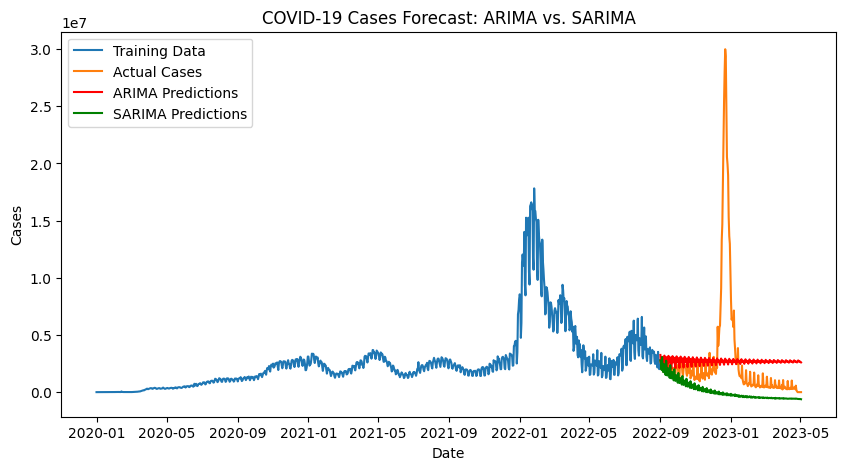

In [16]:
# Import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load the dataset
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
data = pd.read_csv(url)

# Preprocess the dataset
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.set_index('date', inplace=True)
data = data.groupby('date')[['new_cases', 'total_vaccinations']].sum().reset_index()
data.set_index('date', inplace=True)

# Replace missing values in 'total_vaccinations' with zeros
data['total_vaccinations'].fillna(0, inplace=True)

# Train-test split
split_ratio = 0.8
split_index = int(split_ratio * len(data))
train_data = data[:split_index]
test_data = data[split_index:]

# Find optimal ARIMA parameters
arima_model = auto_arima(train_data['new_cases'], seasonal=False, stepwise=True,
                         suppress_warnings=True, max_order=None,
                         trace=False, error_action='ignore')

# Find optimal SARIMA parameters
sarima_model = auto_arima(train_data['new_cases'], exogenous=train_data[['total_vaccinations']],
                          seasonal=True, m=7, stepwise=True,
                          suppress_warnings=True, max_order=None,
                          trace=False, error_action='ignore')

# Train and forecast with ARIMA
arima = SARIMAX(train_data['new_cases'], order=arima_model.order)
arima = arima.fit()
arima_forecast = arima.predict(start=test_data.index[0], end=test_data.index[-1])

# Train and forecast with SARIMA
sarima = SARIMAX(train_data['new_cases'], exog=train_data[['total_vaccinations']],
                 order=sarima_model.order, seasonal_order=sarima_model.seasonal_order)
sarima = sarima.fit()
sarima_forecast = sarima.predict(start=test_data.index[0], end=test_data.index[-1],
                                  exog=test_data[['total_vaccinations']])

# Calculate evaluation metrics for both models
arima_rmse = sqrt(mean_squared_error(test_data['new_cases'], arima_forecast))
sarima_rmse = sqrt(mean_squared_error(test_data['new_cases'], sarima_forecast))

arima_mae = mean_absolute_error(test_data['new_cases'], arima_forecast)
sarima_mae = mean_absolute_error(test_data['new_cases'], sarima_forecast)

arima_mape = mean_absolute_percentage_error(test_data['new_cases'], arima_forecast)
sarima_mape = mean_absolute_percentage_error(test_data['new_cases'], sarima_forecast)

# Print results
print("ARIMA vs. SARIMA Performance:")
print(f"RMSE: {arima_rmse:.2f} vs. {sarima_rmse:.2f}")
print(f"MAE: {arima_mae:.2f} vs. {sarima_mae:.2f}")

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(train_data['new_cases'], label='Training Data')
plt.plot(test_data['new_cases'], label='Actual Cases')
plt.plot(arima_forecast, label='ARIMA Predictions', color='red')
plt.plot(sarima_forecast, label='SARIMA Predictions', color='green')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('COVID-19 Cases Forecast: ARIMA vs. SARIMA')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

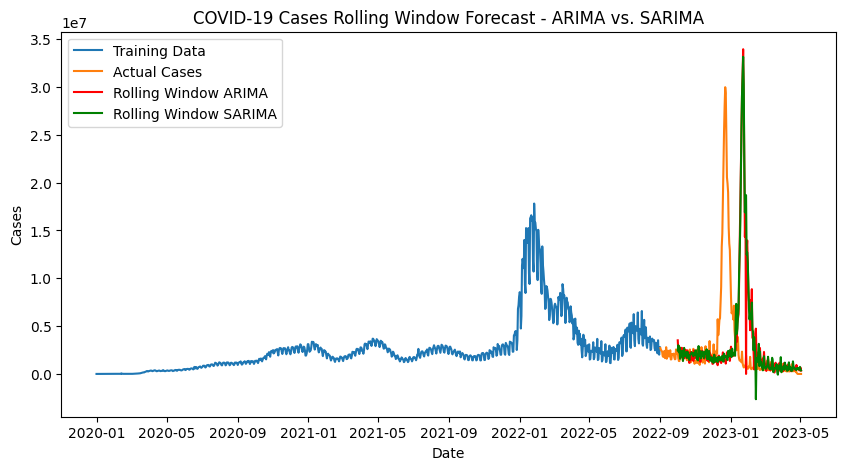

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the dataset
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
data = pd.read_csv(url)

# Preprocess the dataset
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.set_index('date', inplace=True)
data = data.groupby('date')[['new_cases', 'total_vaccinations']].sum().reset_index()
data.set_index('date', inplace=True)
data['total_vaccinations'].fillna(0, inplace=True)

# Train-test split
split_ratio = 0.8
split_index = int(split_ratio * len(data))
train_data = data[:split_index]
test_data = data[split_index:]

# Find optimal ARIMA and SARIMA parameters
arima_model = auto_arima(train_data['new_cases'], seasonal=False, stepwise=True,
                         suppress_warnings=True, max_order=None,
                         trace=False, error_action='ignore')

sarima_model = auto_arima(train_data['new_cases'], exogenous=train_data[['total_vaccinations']],
                          seasonal=True, m=7, stepwise=True,
                          suppress_warnings=True, max_order=None,
                          trace=False, error_action='ignore')

# Rolling window forecasting
window_size = 30
rolling_forecast_arima = []
rolling_forecast_sarima = []

for start_idx in range(len(train_data), len(data) - window_size):
    train_data = data[start_idx - window_size : start_idx]
    exog_train = train_data[['total_vaccinations']]

    # ARIMA
    arima = SARIMAX(train_data['new_cases'], order=arima_model.order)
    arima = arima.fit()
    forecast_arima = arima.predict(start=data.index[start_idx], end=data.index[start_idx])
    rolling_forecast_arima.append(forecast_arima[0])

    # SARIMA
    sarima = SARIMAX(train_data['new_cases'], exog=exog_train,
                     order=sarima_model.order, seasonal_order=sarima_model.seasonal_order)
    sarima = sarima.fit()
    exog_test = data.loc[data.index[start_idx], 'total_vaccinations']
    forecast_sarima = sarima.predict(start=data.index[start_idx], end=data.index[start_idx],
                                      exog=pd.DataFrame([exog_test], columns=['total_vaccinations']))
    rolling_forecast_sarima.append(forecast_sarima[0])

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(data[:split_index]['new_cases'], label='Training Data')
plt.plot(data[split_index:]['new_cases'], label='Actual Cases')
plt.plot(data.index[-len(rolling_forecast_arima):], rolling_forecast_arima, label='Rolling Window ARIMA', color='red')
plt.plot(data.index[-len(rolling_forecast_sarima):], rolling_forecast_sarima, label='Rolling Window SARIMA', color='green')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('COVID-19 Cases Rolling Window Forecast - ARIMA vs. SARIMA')
plt.legend()
plt.show()


In [11]:
!pip install pandas numpy matplotlib seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


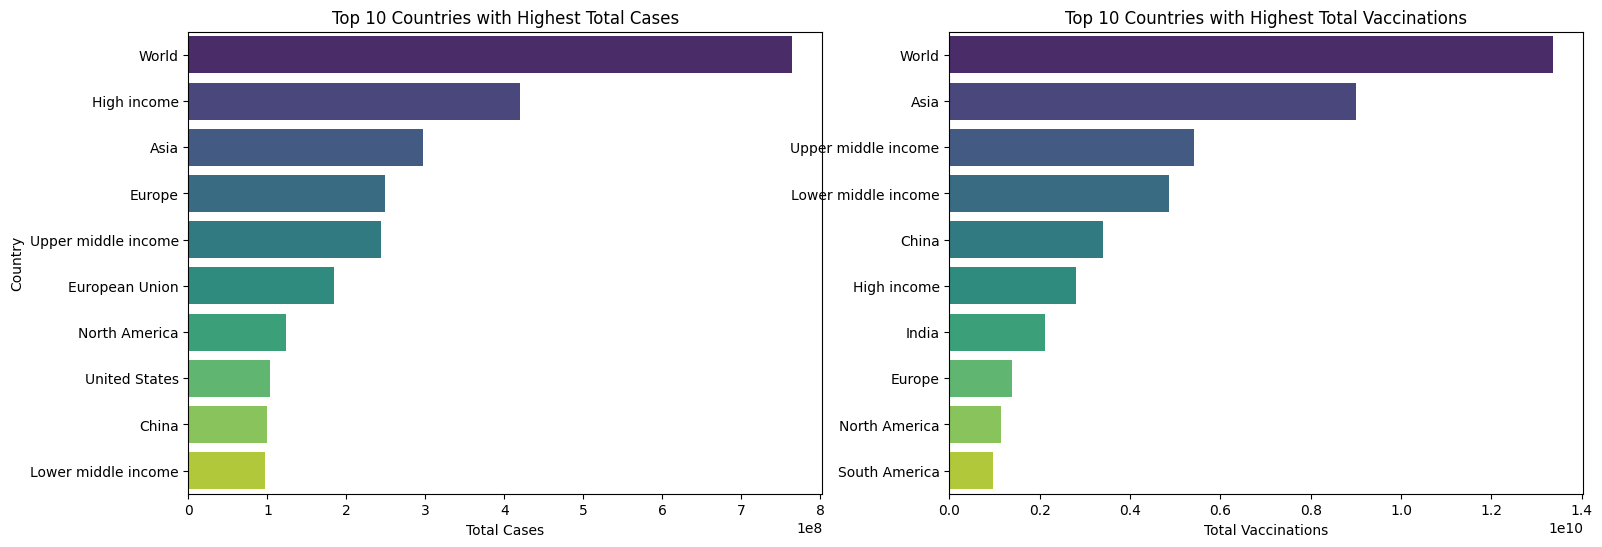

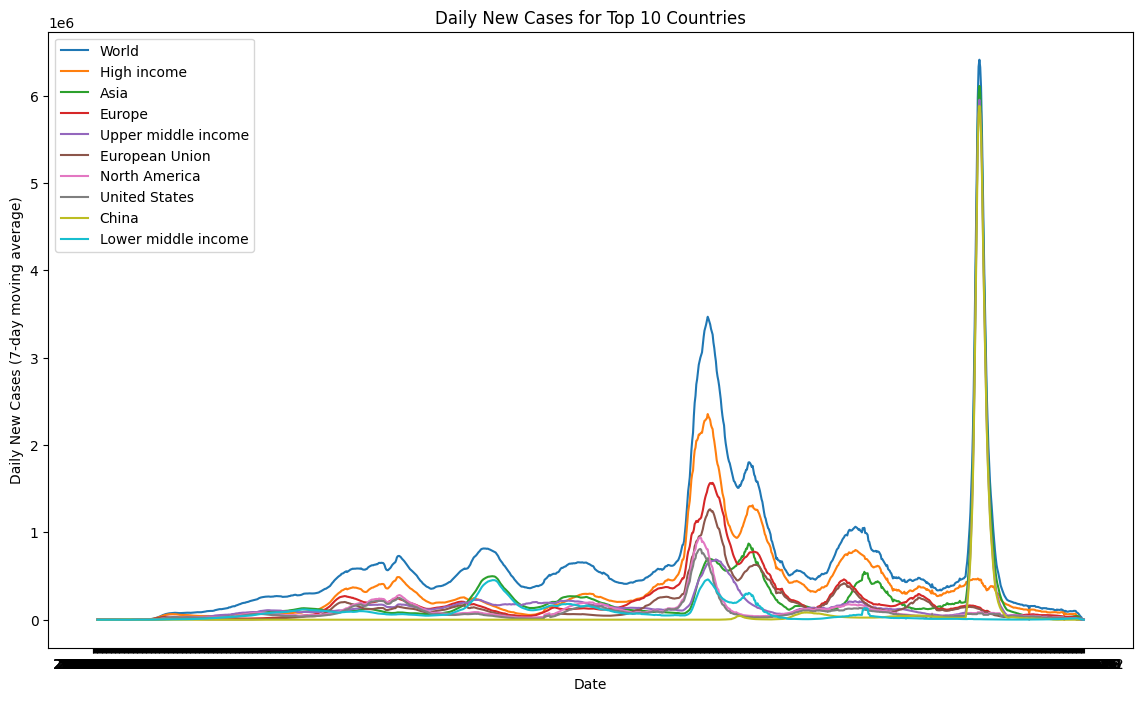

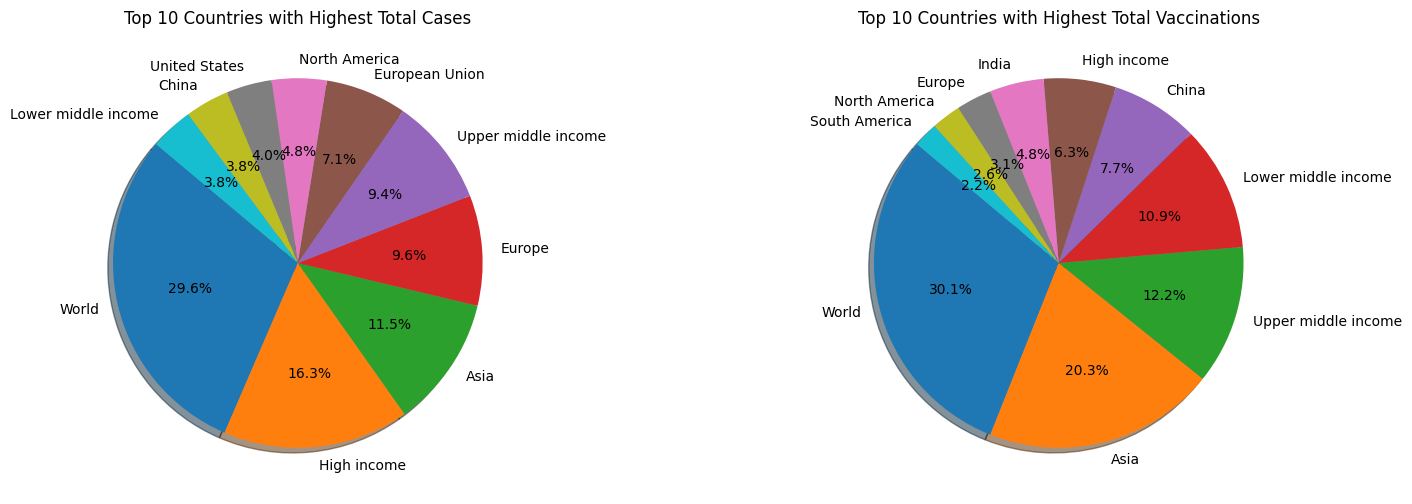

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
data = pd.read_csv(url)

# Group the data by location
grouped_data = data.groupby('location')[['new_cases', 'new_vaccinations']].sum().reset_index()

# Sort by total cases and vaccinations
top_cases = grouped_data.nlargest(10, 'new_cases')
top_vaccinations = grouped_data.nlargest(10, 'new_vaccinations')

# Bar charts for top 10 countries with highest total cases and vaccinations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.barplot(x='new_cases', y='location', data=top_cases, ax=axes[0], palette='viridis')
axes[0].set_xlabel('Total Cases')
axes[0].set_ylabel('Country')
axes[0].set_title('Top 10 Countries with Highest Total Cases')

sns.barplot(x='new_vaccinations', y='location', data=top_vaccinations, ax=axes[1], palette='viridis')
axes[1].set_xlabel('Total Vaccinations')
axes[1].set_ylabel('')
axes[1].set_title('Top 10 Countries with Highest Total Vaccinations')

plt.show()

# Line graph for top 10 countries with highest total cases
plt.figure(figsize=(14, 8))
for country in top_cases['location']:
    country_data = data[data['location'] == country].groupby('date')['new_cases'].sum().rolling(window=7).mean()
    plt.plot(country_data, label=country)

plt.xlabel('Date')
plt.ylabel('Daily New Cases (7-day moving average)')
plt.title('Daily New Cases for Top 10 Countries')
plt.legend()
plt.show()

# Pie charts for top 10 countries with highest total cases and vaccinations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

axes[0].pie(top_cases['new_cases'], labels=top_cases['location'], autopct='%1.1f%%',
            shadow=True, startangle=140)
axes[0].set_title('Top 10 Countries with Highest Total Cases')

axes[1].pie(top_vaccinations['new_vaccinations'], labels=top_vaccinations['location'], autopct='%1.1f%%',
            shadow=True, startangle=140)
axes[1].set_title('Top 10 Countries with Highest Total Vaccinations')

plt.show()
